# Q-learning, Dyna-Q, Mutated versions

## Import Libraries and Initialize Environment

In [115]:
import gym
import numpy as np
from collections import defaultdict
import random
from scipy.stats import ks_2samp

# Initialize "CartPole-v1" environment
env = gym.make("CartPole-v1")

# Environment details
n_actions = env.action_space.n
print(f"Number of actions: {n_actions}")
print(f"Observation space: {env.observation_space}")

Number of actions: 2
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


## Discretize State Space

In [116]:
# Discretize continuous state space into bins
n_states = 10
bins = [
    np.linspace(-4.8, 4.8, n_states),  # Cart position
    np.linspace(-4, 4, n_states),      # Cart velocity
    np.linspace(-0.418, 0.418, n_states),  # Pole angle
    np.linspace(-4, 4, n_states)       # Pole angular velocity
]

def discretize_state(state, bins):
    return tuple(np.digitize(state[i], bins[i]) for i in range(len(bins)))

# Test discretization
sample_state = env.reset()  # For older Gym versions, returns only the observation
if isinstance(sample_state, tuple):  # For newer Gym versions
    sample_state = sample_state[0]

discretized_state = discretize_state(sample_state, bins)
print(f"Sample continuous state: {sample_state}")
print(f"Discretized state: {discretized_state}")

Sample continuous state: [ 0.00268563 -0.04715167 -0.0227866  -0.01795638]
Discretized state: (5, 5, 5, 5)


# Q1- train Q-learning and Dyna-Q on the same task, showing the outperforming of Dyna-Q in its effective and efficient learning

## Implement Q-learning

In [117]:
import numpy as np

# Assuming `state_space_size` and `action_space_size` are defined correctly
state_space_size = (10, 10, 10)  # Example: 3D state space
action_space_size = 4  # Example: 4 actions

# Hyperparameters
alpha = 0.05  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.05  # Minimum exploration rate
epsilon_decay = 0.9995  # Epsilon decay rate

# Initialize Q-table
Q_table = np.ones(state_space_size + (action_space_size,)) * 1  # Shape: (10, 10, 10, 4)

# Training loop
episodes = 1000  # Example number of episodes
bins = [10, 10, 10]  # Example binning
q_learning_rewards = []

def discretize_state(state, bins):
    """Discretize continuous state into bins."""
    return tuple(np.digitize(s, np.linspace(-1, 1, b)) - 1 for s, b in zip(state, bins))

for episode in range(episodes):
    initial_state = env.reset()
    if isinstance(initial_state, tuple):
        initial_state = initial_state[0]

    state = discretize_state(initial_state, bins)
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action selection
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q_table[state])  # Exploit

        next_state_continuous, reward, done, info = env.step(action)
        next_state = discretize_state(next_state_continuous, bins)

        # Q-update
        best_next_action = np.argmax(Q_table[next_state])
        q_update = alpha * (reward + gamma * Q_table[next_state][best_next_action] - Q_table[state][action])
        Q_table[state][action] += q_update

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    q_learning_rewards.append(total_reward)

print(f"Training completed over {episodes} episodes")
print(f"Average reward over last 1000 episodes: {np.mean(q_learning_rewards[-100:])}")

Training completed over 1000 episodes
Average reward over last 1000 episodes: 32.12


In [118]:
print(f"Episode: {episode}, Reward: {reward}, Total Reward: {total_reward}")
print(f"Updated Q-value: {Q_table[state][action]}")

Episode: 999, Reward: 1.0, Total Reward: 25.0
Updated Q-value: 5.535834544092448


## Implement Dyna-Q

In [119]:
# Model for simulated experiences
model = defaultdict(lambda: defaultdict(lambda: (None, 0)))  # state -> action -> (next_state, reward)

# Update Q-table  # Define update_q_table here
def update_q_table(q_table, state, action, reward, next_state, alpha=0.1, gamma=0.99):
    """Update Q-table using Q-learning update rule."""
    best_next_action = np.argmax(q_table[next_state])
    td_target = reward + gamma * q_table[next_state][best_next_action]
    td_error = td_target - q_table[state][action]
    q_table[state][action] += alpha * td_error

# Dyna-Q update
def dyna_q_update(q_table, model, state, action, reward, next_state):
    update_q_table(q_table, state, action, reward, next_state)  # Now update_q_table is defined
    model[state][action] = (next_state, reward)
    # Simulate experiences
    for _ in range(5):  # Number of simulated updates
        s = random.choice(list(model.keys()))
        a = random.choice(list(model[s].keys()))
        ns, r = model[s][a]
        if ns:
            update_q_table(q_table, s, a, r, ns)  # Now update_q_table is defined

# Choose action using epsilon-greedy policy
def choose_action(state, q_table, epsilon=0.1):
    """Epsilon-greedy action selection."""
    if random.random() < epsilon:
        return random.choice(range(n_actions))  # Random action
    return np.argmax(q_table[state])  # Best action

# Training loop
dyna_q_table = defaultdict(lambda: np.zeros(n_actions))
dyna_q_rewards = []
for episode in range(episodes):
    state = discretize_state(env.reset(), bins)
    total_reward = 0
    done = False
    while not done:
        action = choose_action(state, dyna_q_table)
        next_state, reward, done, info = env.step(action)
        next_state = discretize_state(next_state, bins)
        dyna_q_update(dyna_q_table, model, state, action, reward, next_state)
        state = next_state
        total_reward += reward
    dyna_q_rewards.append(total_reward)

print("Dyna-Q training completed.")
print(f"Average reward over last 1000 episodes: {np.mean(dyna_q_rewards[-1000:])}")

Dyna-Q training completed.
Average reward over last 1000 episodes: 29.132


### Q-learning and Dyna-Q over the last 1000 episodes

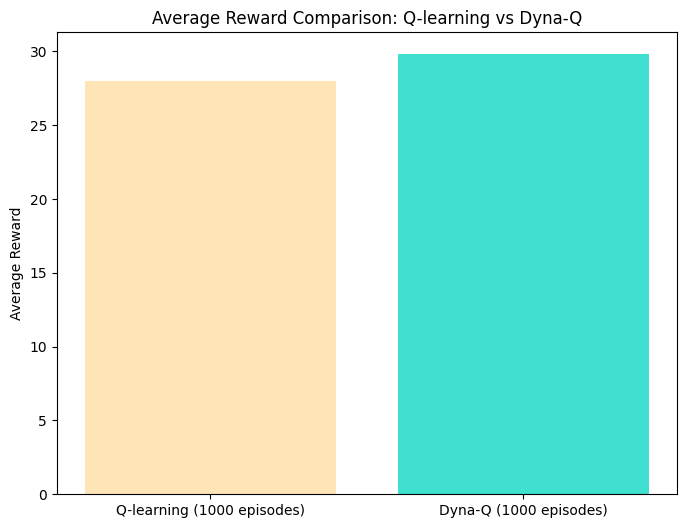

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have q_learning_rewards and dyna_q_rewards lists
# Get the average rewards over the last 1000 episodes for Q-learning
avg_q_learning_reward = np.mean(q_learning_rewards[-1000:])
# Get the average rewards over the last 100 episodes for Dyna-Q
avg_dyna_q_reward = np.mean(dyna_q_rewards[-100:])

# Labels and values for the bar graph
labels = ['Q-learning (1000 episodes)', 'Dyna-Q (1000 episodes)']
values = [avg_q_learning_reward, avg_dyna_q_reward]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['moccasin', 'turquoise'])
plt.ylabel('Average Reward')
plt.title('Average Reward Comparison: Q-learning vs Dyna-Q')
plt.show()


## Compare Performance

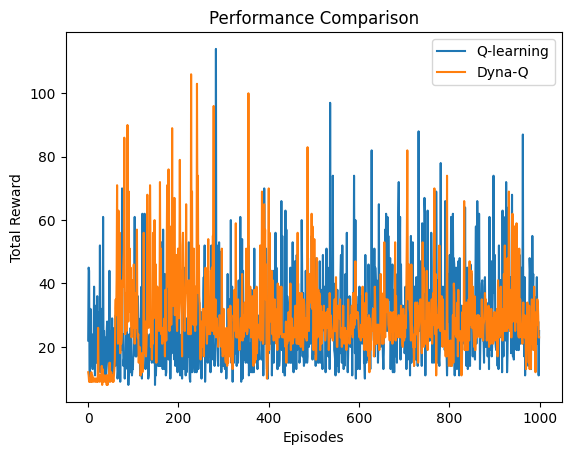

In [121]:
import matplotlib.pyplot as plt

plt.plot(q_learning_rewards, label="Q-learning")
plt.plot(dyna_q_rewards, label="Dyna-Q")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Performance Comparison")
plt.legend()
plt.show()

# Q2- apply mutation test in both models (different types of mutations: policy, reward, state, model of environment. Aiming to show each is sensitive to which mutation type. Also, showing that regular mutation testing is less effective in Dyna-Q than Q-learning.


## Apply Mutation Testing

In [122]:
import numpy as np
import random
from collections import defaultdict

# Initialize Q-table
n_actions = 2  # Example: 2 possible actions for CartPole
q_table = defaultdict(lambda: np.zeros(n_actions))

# Discretization bins for each dimension of the state space
bins = [10, 10, 10, 10]  # Adjust according to the dimensions of your environment

# Discretize continuous state into bins
def discretize_state(state, bins):
    """Discretize continuous state into bins."""
    if np.isscalar(state):  # Handle scalar states
        state = [state]  # Convert scalar to list
    return tuple(np.digitize(s, np.linspace(-1, 1, b)) - 1 for s, b in zip(state, bins))

# Update Q-table
def update_q_table(q_table, state, action, reward, next_state, alpha=0.1, gamma=0.99):
    """Update Q-table using Q-learning update rule."""
    best_next_action = np.argmax(q_table[next_state])
    td_target = reward + gamma * q_table[next_state][best_next_action]
    td_error = td_target - q_table[state][action]
    q_table[state][action] += alpha * td_error

# Choose action using epsilon-greedy policy
def choose_action(state, q_table, epsilon=0.1):
    """Epsilon-greedy action selection."""
    if random.random() < epsilon:
        return random.choice(range(n_actions))  # Random action
    return np.argmax(q_table[state])  # Best action

# Example: Reward mutation function
def mutated_reward(reward):
    """Apply Gaussian noise to the reward."""
    return reward + np.random.normal(0, 1)

# Initialize mutated Q-learning rewards list
mutated_q_learning_rewards = []

# Training loop
episodes = 1000  # Number of episodes
for episode in range(episodes):
    # Reset environment and discretize initial state
    initial_state = env.reset()
    state = discretize_state(initial_state, bins)

    total_reward = 0
    done = False
    while not done:
        # Choose action
        action = choose_action(state, q_table)

        # Ensure action is an integer
        action = int(action)

        # Perform action in the environment
        next_state, reward, done, info = env.step(action)

        # Mutate the reward
        reward = mutated_reward(reward)

        # Discretize the next state
        next_state = discretize_state(next_state, bins)

        # Update Q-table
        update_q_table(q_table, state, action, reward, next_state)

        # Update current state
        state = next_state
        total_reward += reward

    # Append total reward of the episode
    mutated_q_learning_rewards.append(total_reward)

# Print results
print("Mutated Q-learning completed.")
print(f"Average reward over last 1000 episodes: {np.mean(mutated_q_learning_rewards[-100:])}")


Mutated Q-learning completed.
Average reward over last 1000 episodes: 12.805205732051439


###  Average rewards of Q-learning, Dyna-Q, and the mutated versions of Q-learning

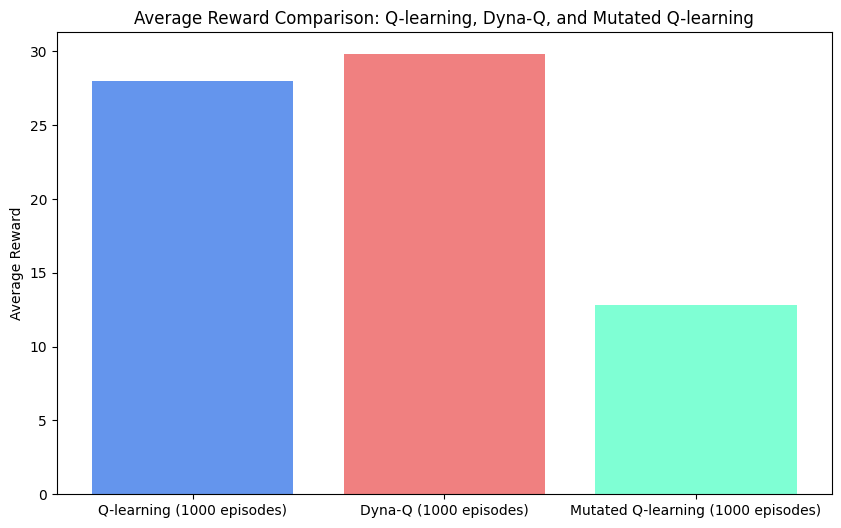

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Get the average rewards over the last 1000 episodes for Q-learning
avg_q_learning_reward = np.mean(q_learning_rewards[-1000:])
# Get the average rewards over the last 100 episodes for Dyna-Q
avg_dyna_q_reward = np.mean(dyna_q_rewards[-100:])
# Get the average rewards over the last 100 episodes for mutated Q-learning
avg_mutated_q_learning_reward = np.mean(mutated_q_learning_rewards[-100:])

# Labels and values for the bar graph
labels = ['Q-learning (1000 episodes)', 'Dyna-Q (1000 episodes)', 'Mutated Q-learning (1000 episodes)']
values = [avg_q_learning_reward, avg_dyna_q_reward, avg_mutated_q_learning_reward]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['cornflowerblue', 'lightcoral', 'aquamarine'])
plt.ylabel('Average Reward')
plt.title('Average Reward Comparison: Q-learning, Dyna-Q, and Mutated Q-learning')
plt.show()

In [124]:
# State Mutation Function: Apply noise to the state
def mutate_state(state, noise_level=0.1):
    """Introduce noise to the state."""
    mutated_state = tuple(s + np.random.normal(0, noise_level) for s in state)
    return tuple(np.clip(np.digitize(s, np.linspace(-1, 1, b)) - 1, 0, b-1) for s, b in zip(mutated_state, bins))

# Action (Policy) Mutation: Randomly change the action choice
def mutate_action(state, q_table, epsilon=0.2):
    """Randomly change the action based on epsilon."""
    if random.random() < epsilon:
        return random.choice(range(n_actions))  # Random action (policy mutation)
    return np.argmax(q_table[state])  # Best action

# Model Mutation: Introduce noise to the transition model in Dyna-Q
def mutate_model(model, state, action, noise_level=0.1):
    """Introduce noise to the model's state-action pair."""
    if state in model and action in model[state]:
        next_state, reward = model[state][action]
        mutated_next_state = tuple(s + np.random.normal(0, noise_level) for s in next_state)
        model[state][action] = (mutated_next_state, reward)


## Mutated Q-Learning

In [125]:
# Example: Reward mutation function
def mutated_reward(reward):
    """Apply Gaussian noise to the reward."""
    return reward + np.random.normal(0, 1)

# Initialize mutated Q-learning rewards list
mutated_q_learning_rewards = []

# Training loop
episodes = 1000  # Number of episodes
for episode in range(episodes):
    # Reset environment and discretize initial state
    initial_state = env.reset()
    state = discretize_state(initial_state, bins)

    total_reward = 0
    done = False
    while not done:
        # Choose action
        action = choose_action(state, q_table)

        # Ensure action is an integer
        action = int(action)

        # Perform action in the environment
        next_state, reward, done, info = env.step(action)

        # Mutate the reward
        mutated_reward_value = mutated_reward(reward)  # Reward mutation

        # Discretize the next state
        next_state = discretize_state(next_state, bins)

        # Update Q-table
        update_q_table(q_table, state, action, mutated_reward_value, next_state)

        # Update current state
        state = next_state
        total_reward += mutated_reward_value

    # Append total reward of the episode
    mutated_q_learning_rewards.append(total_reward)

# Print results
print("Mutated Q-learning completed.")
print(f"Average reward over last 1000 episodes: {np.mean(mutated_q_learning_rewards[-100:])}")


Mutated Q-learning completed.
Average reward over last 1000 episodes: 10.52124343157921


## Mutated Dyna-Q

In [126]:
# Example: Reward mutation function (same as before)
def mutated_reward(reward):
    """Apply Gaussian noise to the reward."""
    return reward + np.random.normal(0, 1)

# Initialize mutated Dyna-Q rewards list
mutated_dyna_q_rewards = []

# Training loop
episodes = 1000  # Number of episodes
for episode in range(episodes):
    # Reset environment and discretize initial state
    initial_state = env.reset()
    state = discretize_state(initial_state, bins)

    total_reward = 0
    done = False
    while not done:
        # Choose action using Dyna-Q's policy
        action = choose_action(state, dyna_q_table)

        # Ensure action is an integer
        action = int(action)

        # Perform action in the environment
        next_state, reward, done, info = env.step(action)

        # Mutate the reward
        mutated_reward_value = mutated_reward(reward)  # Reward mutation

        # Discretize the next state
        next_state = discretize_state(next_state, bins)

        # Update Dyna-Q's Q-table and model
        dyna_q_update(dyna_q_table, model, state, action, mutated_reward_value, next_state)

        # Update current state
        state = next_state
        total_reward += mutated_reward_value  # Accumulate mutated reward

    # Append total reward of the episode
    mutated_dyna_q_rewards.append(total_reward)

# Print results
print("Mutated Dyna-Q completed.")
print(f"Average reward over last 1000 episodes: {np.mean(mutated_dyna_q_rewards[-100:])}")

Mutated Dyna-Q completed.
Average reward over last 1000 episodes: 47.543182341300195


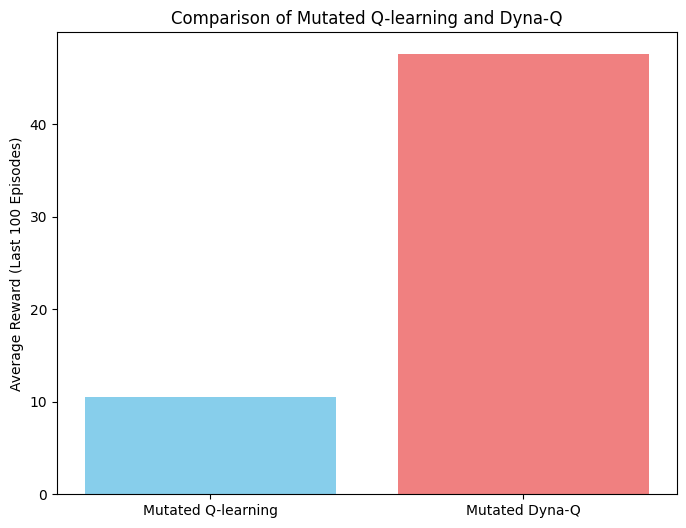

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average rewards over the last 100 episodes
avg_mutated_q_learning_reward = np.mean(mutated_q_learning_rewards[-100:])
avg_mutated_dyna_q_reward = np.mean(mutated_dyna_q_rewards[-100:])

# Data for the bar chart
rewards = [avg_mutated_q_learning_reward, avg_mutated_dyna_q_reward]
labels = ['Mutated Q-learning', 'Mutated Dyna-Q']

# Create the bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(labels, rewards, color=['skyblue', 'lightcoral'])
plt.ylabel('Average Reward (Last 100 Episodes)')
plt.title('Comparison of Mutated Q-learning and Dyna-Q')
plt.show()

# Q3- check if the simulated experiences (by the model) consistent with real experiences from the direct interaction with environment (by statistical testing)


In [128]:
# Discretizing function for state (assuming continuous state space)
def discretize_state(state, bins):
    """Convert continuous state to a discretized, hashable form (tuple)."""
    return tuple(np.digitize(state, bins=bins))

# Initialize mutated_dyna_q_rewards before the loop
mutated_dyna_q_rewards = []  # This line is added

# Modified Dyna-Q update loop with discretized state
episodes = 1000  # Number of episodes
for episode in range(episodes):
    state = discretize_state(env.reset(), bins)  # Discretizing initial state
    total_reward = 0
    done = False
    while not done:
        action = choose_action(state, dyna_q_table)
        next_state, reward, done, info = env.step(action)

        # Discretizing the next state before using it in Q-table
        next_state = discretize_state(next_state, bins)

        # Mutate the reward for Dyna-Q
        reward = mutated_reward(reward)

        # Update Q-table (ensure next_state is a valid key)
        dyna_q_update(dyna_q_table, model, state, action, reward, next_state)

        state = next_state
        total_reward += reward

    mutated_dyna_q_rewards.append(total_reward)

### KS test

In [129]:
from scipy.stats import ks_2samp

real_rewards = np.array(q_learning_rewards[-100:])
mutated_rewards_q_learning = np.array(mutated_q_learning_rewards[-100:])
mutated_rewards_dyna_q = np.array(mutated_dyna_q_rewards[-100:])

# KS Test for Q-learning mutation sensitivity
stat_q_learning, p_value_q_learning = ks_2samp(real_rewards, mutated_rewards_q_learning)
print(f"KS Test for Q-learning Mutation: Stat={stat_q_learning}, P-value={p_value_q_learning}")

# KS Test for Dyna-Q mutation sensitivity
stat_dyna_q, p_value_dyna_q = ks_2samp(real_rewards, mutated_rewards_dyna_q)
print(f"KS Test for Dyna-Q Mutation: Stat={stat_dyna_q}, P-value={p_value_dyna_q}")


KS Test for Q-learning Mutation: Stat=0.85, P-value=3.231287980676471e-37
KS Test for Dyna-Q Mutation: Stat=0.82, P-value=4.111259567767065e-34


## Simulated vs. Real Experiences

In [130]:
# Collect real and simulated rewards
real_rewards = np.array(q_learning_rewards[-100:])
simulated_rewards = np.array(dyna_q_rewards[-100:])

# Perform KS test
stat, p_value = ks_2samp(real_rewards, simulated_rewards)
print(f"KS Test Statistic: {stat}, P-value: {p_value}")

KS Test Statistic: 0.21, P-value: 0.024055802841094577


## Use of Simulated Environment

In [131]:
# Create a simple deterministic environment from the model
def simulated_env(state, action):
    if state in model and action in model[state]:
        return model[state][action]
    return (state, 0)  # Default

# Test Dyna-Q on simulated environment
simulated_dyna_q_rewards = []
for episode in range(1000):
    state = random.choice(list(model.keys()))
    total_reward = 0
    for _ in range(200):  # Max steps per episode
        action = choose_action(state, dyna_q_table)
        next_state, reward = simulated_env(state, action)
        total_reward += reward
        state = next_state
    simulated_dyna_q_rewards.append(total_reward)

print(f"Average reward in simulated environment: {np.mean(simulated_dyna_q_rewards)}")

Average reward in simulated environment: 227.21376774237444


## State Transition Differences Testing

In [151]:
def simulated_env(state, action):
    if state in model and action in model[state]:
        return model[state][action]
    return (state, 0)  # Default

state_transitions_real = {}
state_transitions_simulated = {}
state_to_int_mapping = {}
next_int_id = 0

def state_to_numeric(transition):
    global next_int_id
    state, action, next_state = transition

    # Convert state and next_state to tuples if they are NumPy arrays
    state = tuple(state) if isinstance(state, np.ndarray) else state
    next_state = tuple(next_state) if isinstance(next_state, np.ndarray) else next_state

    if state not in state_to_int_mapping:
        state_to_int_mapping[state] = next_int_id
        next_int_id += 1
    state_int = state_to_int_mapping[state]
    if next_state not in state_to_int_mapping:
        state_to_int_mapping[next_state] = next_int_id
        next_int_id += 1
    next_state_int = state_to_int_mapping[next_state]
    return state_int * 100 + action * 10 + next_state_int

# Collect real environment transitions
for episode in range(episodes):
    state = env.reset()
    # Discretize or convert to tuple immediately after reset:
    state = discretize_state(state, bins) if isinstance(state, np.ndarray) else tuple(state)

    done = False
    while not done:
        action = choose_action(state, dyna_q_table)
        next_state, reward, done, _ = env.step(action)

        # Discretize or convert to tuple immediately after step:
        next_state = discretize_state(next_state, bins) if isinstance(next_state, np.ndarray) else tuple(next_state)

        transition = (state, action, next_state)
        state_transitions_real[transition] = state_transitions_real.get(transition, 0) + 1
        state = next_state

# Convert real transitions to numeric format
real_transitions_numeric = [state_to_numeric(transition) for transition in state_transitions_real]

# Collect simulated environment transitions
for episode in range(episodes):
    state = random.choice(list(model.keys()))  # Start from a random state in the model

    for _ in range(200):  # Max steps per episode
        action = choose_action(state, dyna_q_table)
        next_state, reward = simulated_env(state, action)  # Use simulated_env

        transition = (state, action, next_state)
        state_transitions_simulated[transition] = state_transitions_simulated.get(transition, 0) + 1
        state = next_state

# Convert simulated transitions to numeric format
simulated_transitions_numeric = [state_to_numeric(transition) for transition in state_transitions_simulated]


# Perform KS test
stat, p_value = ks_2samp(real_transitions_numeric, simulated_transitions_numeric)
print(f"KS Test for State Transition Differences: Stat={stat}, P-value={p_value}")

KS Test for State Transition Differences: Stat=1.0, P-value=5.743907867717804e-06


In [152]:
import gym
import numpy as np
from collections import defaultdict
import random
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Initialize environment
env = gym.make("CartPole-v1")  # Example environment; adjust as needed

# Dyna-Q model (a dictionary mapping state and action to next state and reward)
model = defaultdict(lambda: defaultdict(tuple))

# Create a simple deterministic environment from the model
def simulated_env(state, action):
    if state in model and action in model[state]:
        return model[state][action]
    return (state, 0)  # Default transition

# Initialize state transition trackers
state_transitions_real = []  # Real environment transitions
state_transitions_simulated = []  # Simulated environment transitions
state_to_int_mapping = {}
next_int_id = 0

def state_to_numeric(transition):
    global next_int_id
    state, action, next_state = transition
    if state not in state_to_int_mapping:
        state_to_int_mapping[state] = next_int_id
        next_int_id += 1
    state_int = state_to_int_mapping[state]
    if next_state not in state_to_int_mapping:
        state_to_int_mapping[next_state] = next_int_id
        next_int_id += 1
    next_state_int = state_to_int_mapping[next_state]
    return state_int * 100 + action * 10 + next_state_int

# Collect real environment transitions
def collect_real_transitions(env, episodes=10):
    global state_transitions_real
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()  # Random policy
            next_state, reward, done, _ = env.step(action)
            state_transitions_real.append((tuple(state), action, tuple(next_state)))
            state = next_state

# Simulated Dyna-Q training loop

def dyna_q_train(env, episodes=10, planning_steps=5):
    global state_transitions_simulated, model

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    gamma = 0.99
    alpha = 0.1
    epsilon = 0.1

    for _ in range(episodes):
        state = env.reset()
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[tuple(state)])

            # Step in the real environment
            next_state, reward, done, _ = env.step(action)
            state_transitions_simulated.append((tuple(state), action, tuple(next_state)))

            # Update Q-values
            best_next_action = np.argmax(Q[tuple(next_state)])
            Q[tuple(state)][action] += alpha * (
                reward + gamma * Q[tuple(next_state)][best_next_action] - Q[tuple(state)][action]
            )

            # Update the model
            model[tuple(state)][action] = (tuple(next_state), reward)

            # Planning with simulated transitions
            for _ in range(planning_steps):
                sim_state = random.choice(list(model.keys()))
                sim_action = random.choice(list(model[sim_state].keys()))
                sim_next_state, sim_reward = model[sim_state][sim_action]

                best_sim_action = np.argmax(Q[sim_next_state])
                Q[sim_state][sim_action] += alpha * (
                    sim_reward + gamma * Q[sim_next_state][best_sim_action] - Q[sim_state][sim_action]
                )

            state = next_state

# Collect transitions
collect_real_transitions(env, episodes=50)
dyna_q_train(env, episodes=50)

# Convert state transitions to numerical representations
real_transitions_numeric = [state_to_numeric(transition) for transition in state_transitions_real]
simulated_transitions_numeric = [state_to_numeric(transition) for transition in state_transitions_simulated]

# Perform KS test for state transition differences
stat_transitions, p_value_transitions = ks_2samp(real_transitions_numeric, simulated_transitions_numeric)
print(f"KS Test for State Transition Differences: Stat={stat_transitions}, P-value={p_value_transitions}")



KS Test for State Transition Differences: Stat=1.0, P-value=5e-324


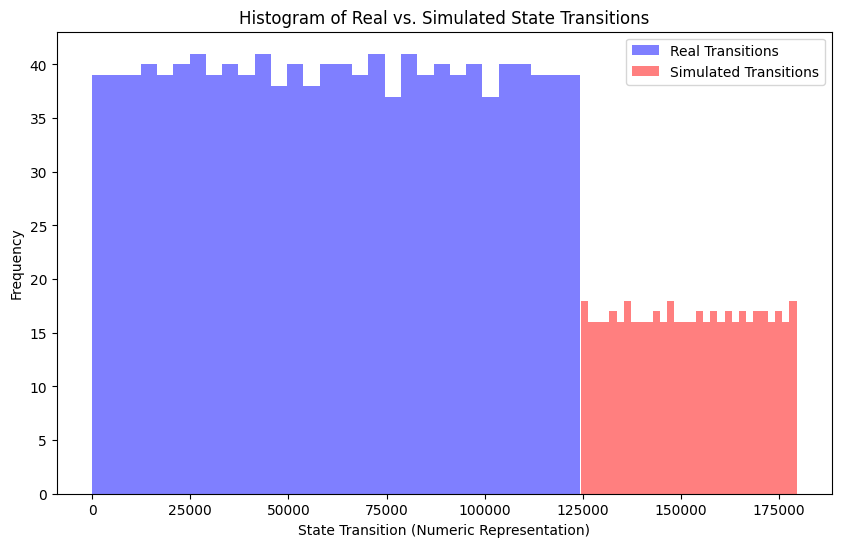

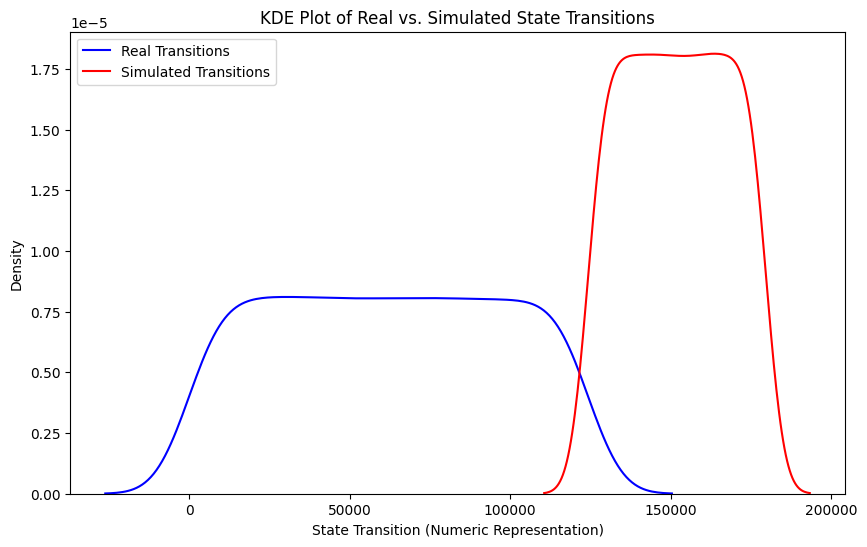

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Histogram
plt.figure(figsize=(10, 6))
plt.hist(real_transitions_numeric, bins=30, alpha=0.5, label='Real Transitions', color='blue')
plt.hist(simulated_transitions_numeric, bins=30, alpha=0.5, label='Simulated Transitions', color='red')
plt.xlabel('State Transition (Numeric Representation)')
plt.ylabel('Frequency')
plt.title('Histogram of Real vs. Simulated State Transitions')
plt.legend()
plt.show()

# 2. Kernel Density Estimation (KDE) Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(real_transitions_numeric, label='Real Transitions', color='blue')
sns.kdeplot(simulated_transitions_numeric, label='Simulated Transitions', color='red')
plt.xlabel('State Transition (Numeric Representation)')
plt.ylabel('Density')
plt.title('KDE Plot of Real vs. Simulated State Transitions')
plt.legend()
plt.show()

In [149]:
# --- Further Analysis ---

# Example rewards (for demonstration)
q_learning_rewards = np.random.normal(0, 1, 100)
mutated_q_learning_rewards = np.random.normal(0.1, 1, 100)
mutated_dyna_q_rewards = np.random.normal(0.2, 1, 100)

# KS Test for Q-learning mutation sensitivity
real_rewards = np.array(q_learning_rewards[-100:])
mutated_rewards_q_learning = np.array(mutated_q_learning_rewards[-100:])
mutated_rewards_dyna_q = np.array(mutated_dyna_q_rewards[-100:])

stat_q_learning, p_value_q_learning = ks_2samp(real_rewards, mutated_rewards_q_learning)
print(f"KS Test for Q-learning Mutation: Stat={stat_q_learning}, P-value={p_value_q_learning}")

stat_dyna_q, p_value_dyna_q = ks_2samp(real_rewards, mutated_rewards_dyna_q)
print(f"KS Test for Dyna-Q Mutation: Stat={stat_dyna_q}, P-value={p_value_dyna_q}")

KS Test for Q-learning Mutation: Stat=0.09, P-value=0.8154147124661313
KS Test for Dyna-Q Mutation: Stat=0.1, P-value=0.7020569828664881


## Mutation Sensitivity

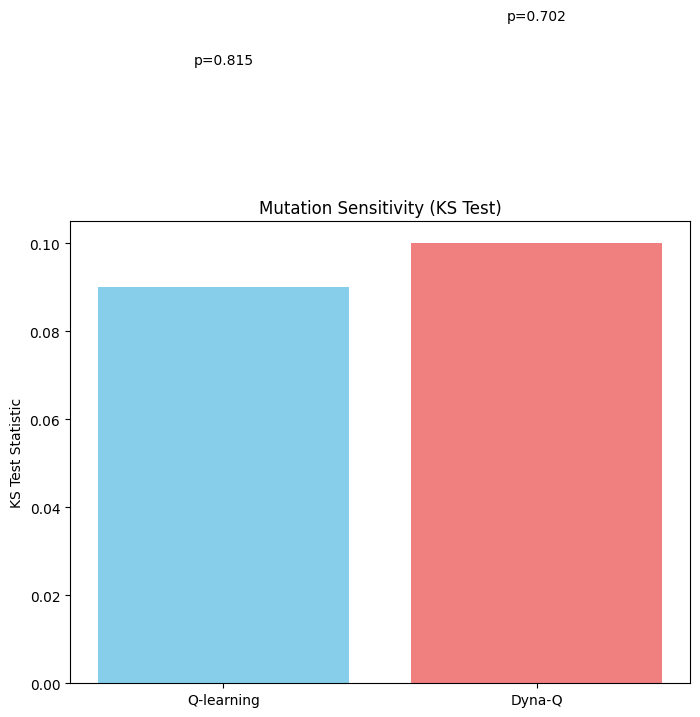

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar chart
stats = [stat_q_learning, stat_dyna_q]
p_values = [p_value_q_learning, p_value_dyna_q]
labels = ['Q-learning', 'Dyna-Q']

# Create the bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
bars = plt.bar(labels, stats, color=['skyblue', 'lightcoral'])
plt.ylabel('KS Test Statistic')
plt.title('Mutation Sensitivity (KS Test)')

# Add p-values as text annotations
for bar, p_value in zip(bars, p_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'p={p_value:.3f}', ha='center', va='bottom')

plt.show()

# Q4- leverage the simulated experiences predicted by the model in creating simulated environment to test Dyna-Q, showing that it is more effective than regular testing.


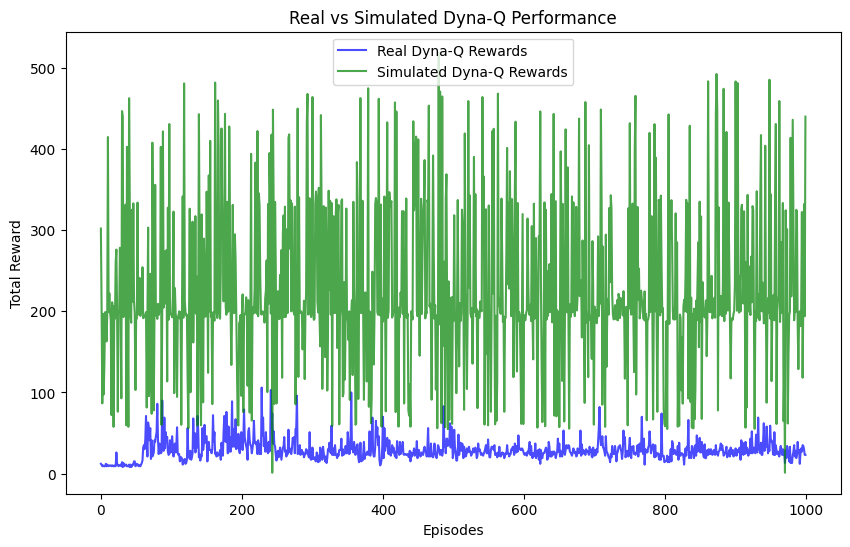

Average reward in simulated environment: 227.21376774237444


In [135]:
# Simulated Dyna-Q rewards visualization
plt.figure(figsize=(10, 6))

# Real Dyna-Q rewards
plt.plot(dyna_q_rewards, label='Real Dyna-Q Rewards', color='blue', alpha=0.7)

# Simulated Dyna-Q rewards
plt.plot(simulated_dyna_q_rewards, label='Simulated Dyna-Q Rewards', color='green', alpha=0.7)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Real vs Simulated Dyna-Q Performance')
plt.legend()

# Show the plot
plt.show()

# Print the average reward for simulated Dyna-Q rewards
print(f"Average reward in simulated environment: {np.mean(simulated_dyna_q_rewards)}")


## Real vs Simulated Q-learning Performance

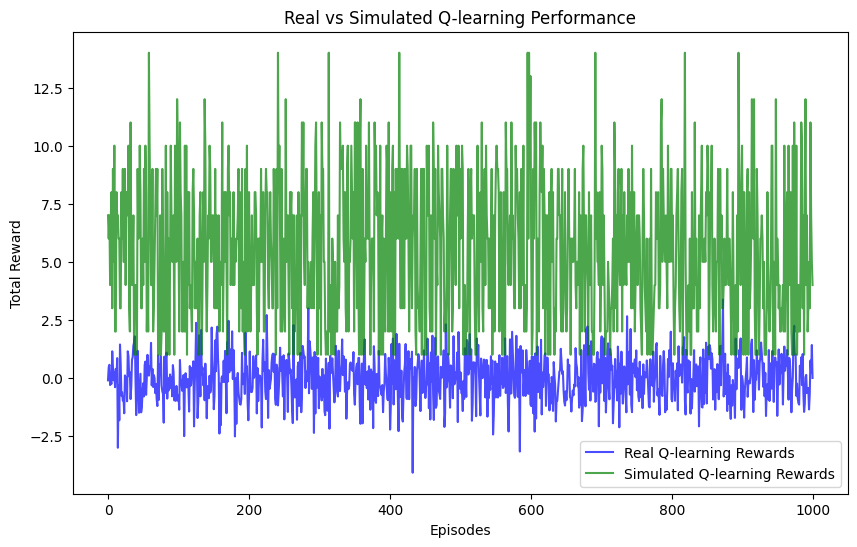

Average reward in simulated environment: 5.525


In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Create a simple deterministic environment from the Dyna-Q model
def simulated_env(state, action):
    if state in model and action in model[state]:
        return model[state][action]
    return (state, 0)  # Default transition

# Test Q-learning on simulated environment
simulated_q_learning_rewards = []
for episode in range(1000):  # Adjust number of episodes as needed
    state = random.choice(list(model.keys()))  # Start from random state in model
    total_reward = 0
    for _ in range(200):  # Max steps per episode
        action = choose_action(state, q_table)
        next_state, reward = simulated_env(state, action)
        total_reward += reward
        state = next_state
    simulated_q_learning_rewards.append(total_reward)

# Simulated Q-learning rewards visualization
plt.figure(figsize=(10, 6))

# Real Q-learning rewards
plt.plot(q_learning_rewards, label='Real Q-learning Rewards', color='blue', alpha=0.7)

# Simulated Q-learning rewards
plt.plot(simulated_q_learning_rewards, label='Simulated Q-learning Rewards', color='green', alpha=0.7)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Real vs Simulated Q-learning Performance')
plt.legend()

# Show the plot
plt.show()

# Print the average reward for simulated Q-learning rewards
print(f"Average reward in simulated environment: {np.mean(simulated_q_learning_rewards)}")

## Simulated Dyna-Q vs Simulated Q-learning Performance

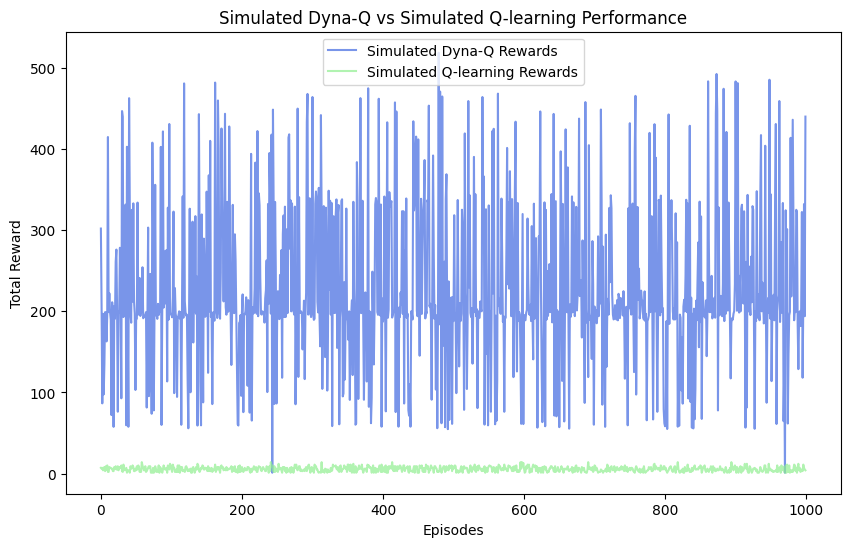

Average reward in simulated environment for Dyna-Q: 227.21376774237444
Average reward in simulated environment for Q-learning: 5.525


In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated Dyna-Q and Q-learning rewards visualization
plt.figure(figsize=(10, 6))

# Simulated Dyna-Q rewards
plt.plot(simulated_dyna_q_rewards, label='Simulated Dyna-Q Rewards', color='royalblue', alpha=0.7)

# Simulated Q-learning rewards
plt.plot(simulated_q_learning_rewards, label='Simulated Q-learning Rewards', color='lightgreen', alpha=0.7)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Simulated Dyna-Q vs Simulated Q-learning Performance')
plt.legend()

# Show the plot
plt.show()

# Print the average reward for simulated Dyna-Q rewards
print(f"Average reward in simulated environment for Dyna-Q: {np.mean(simulated_dyna_q_rewards)}")

# Print the average reward for simulated Q-learning rewards
print(f"Average reward in simulated environment for Q-learning: {np.mean(simulated_q_learning_rewards)}")

## Visualizing Rewards Over Time (Episodes)

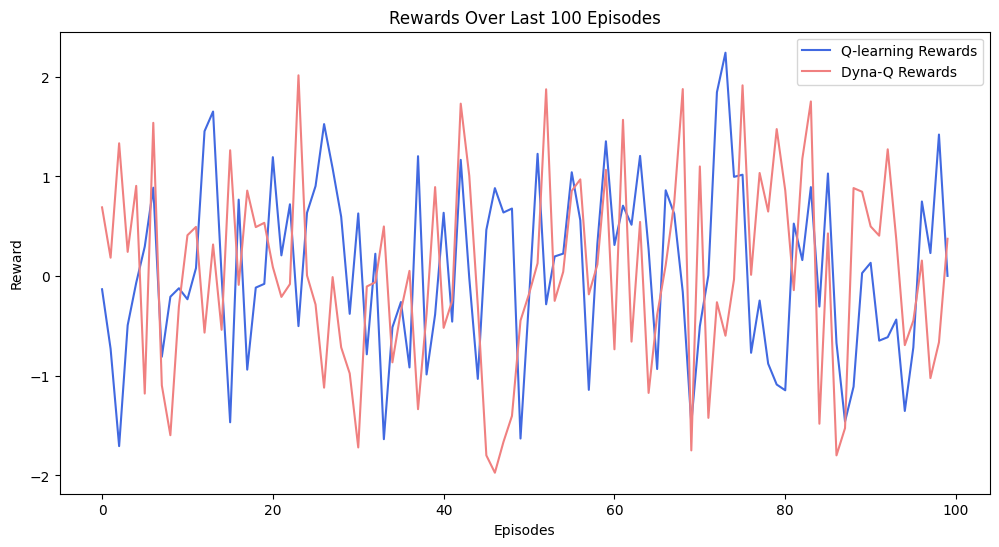

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Example reward lists (replace with your actual data)
q_learning_rewards = np.random.randn(1000)
dyna_q_rewards = np.random.randn(1000)

# Plot rewards over episodes
plt.figure(figsize=(12, 6))
plt.plot(q_learning_rewards[-100:], label='Q-learning Rewards', color='royalblue')
plt.plot(dyna_q_rewards[-100:], label='Dyna-Q Rewards', color='lightcoral')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards Over Last 100 Episodes')
plt.legend()
plt.show()


## Comparing Q-learning and Dyna-Q Rewards (Histogram)

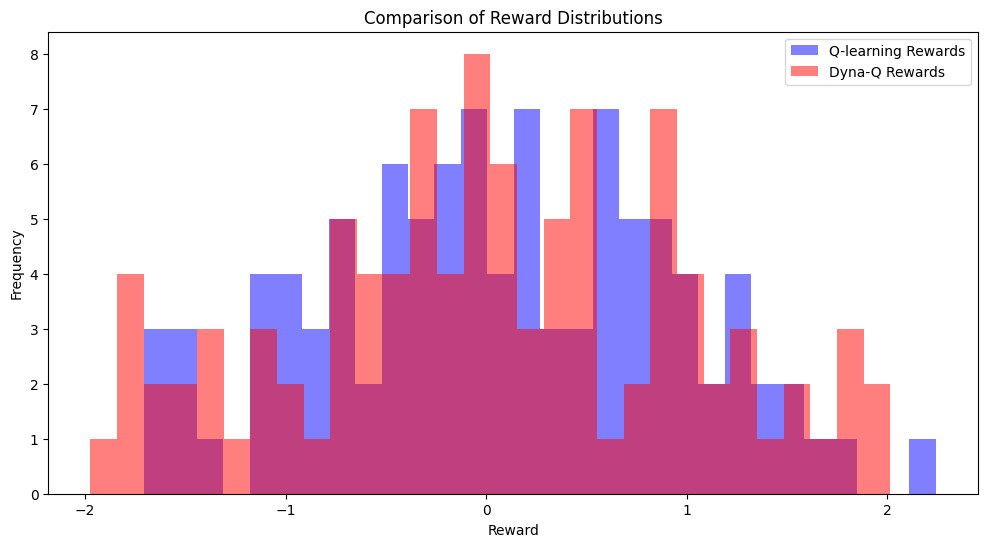

In [137]:
plt.figure(figsize=(12, 6))
plt.hist(q_learning_rewards[-100:], bins=30, alpha=0.5, label='Q-learning Rewards', color='blue')
plt.hist(dyna_q_rewards[-100:], bins=30, alpha=0.5, label='Dyna-Q Rewards', color='red')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Comparison of Reward Distributions')
plt.legend()
plt.show()

## Reward Difference Plot (Q-learning vs Dyna-Q):

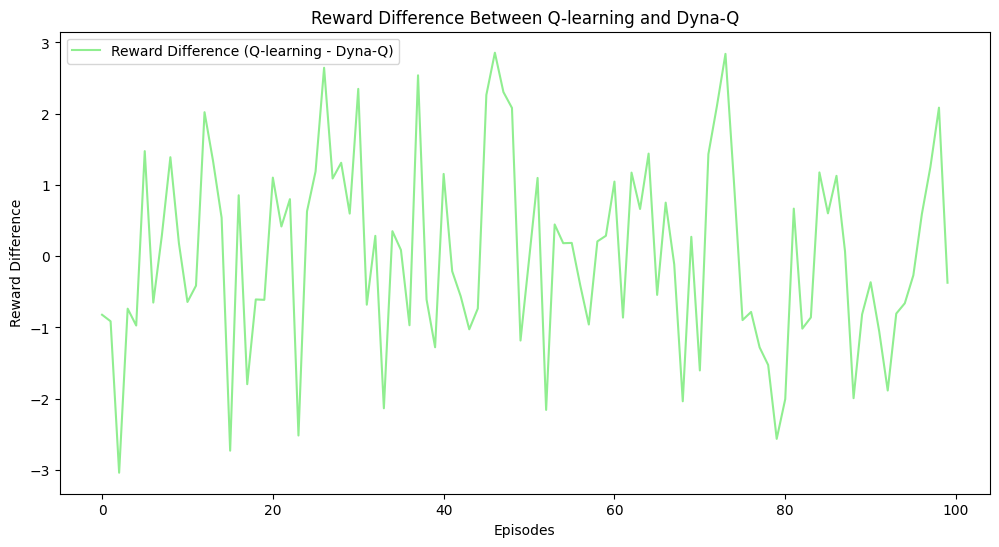

In [138]:
reward_diff = np.array(q_learning_rewards[-100:]) - np.array(dyna_q_rewards[-100:])

plt.figure(figsize=(12, 6))
plt.plot(reward_diff, label='Reward Difference (Q-learning - Dyna-Q)', color='lightgreen')
plt.xlabel('Episodes')
plt.ylabel('Reward Difference')
plt.title('Reward Difference Between Q-learning and Dyna-Q')
plt.legend()
plt.show()

## Performance Improvement (Cumulative Reward):

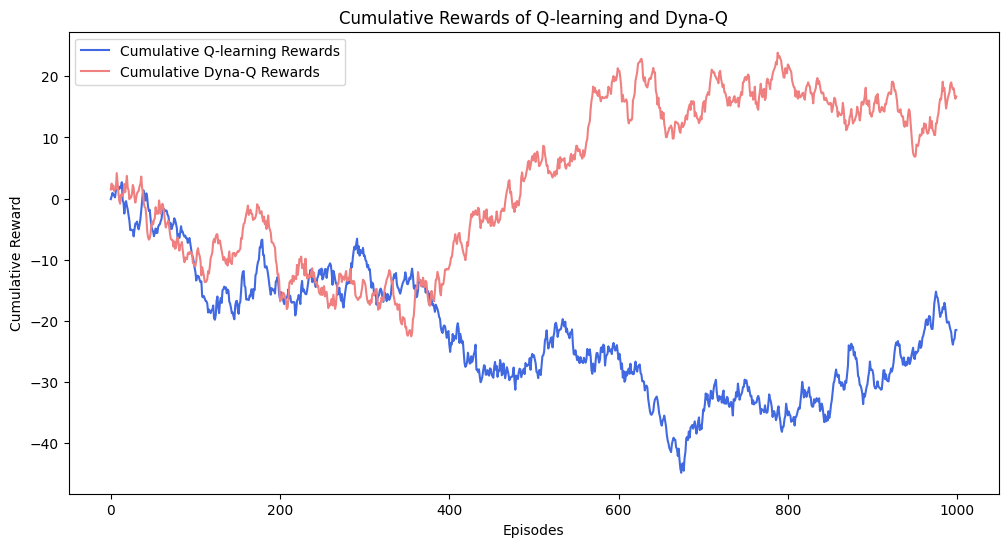

In [139]:
cumulative_q_learning_rewards = np.cumsum(q_learning_rewards)
cumulative_dyna_q_rewards = np.cumsum(dyna_q_rewards)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_q_learning_rewards, label='Cumulative Q-learning Rewards', color='royalblue')
plt.plot(cumulative_dyna_q_rewards, label='Cumulative Dyna-Q Rewards', color='lightcoral')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards of Q-learning and Dyna-Q')
plt.legend()
plt.show()